<a href="https://colab.research.google.com/github/danielhou13/cogs402longformer/blob/main/src/Attributions_Longformer_Token.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook adapts the [Captum tutorial for question answering](https://captum.ai/tutorials/Bert_SQUAD_Interpret) and refactors it into the longformer sequence classification task. Specifically, this notebook focuses on using the model's embeddings for interpreting the longformer's layers by examining the distribution of attribution scores for every token across all layers. We can also pick out a specific token we want to assess by visualizing the raw attribution scores for that token across all layers.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Import and Install Dependencies

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/{}'.format("cogs402longformer/"))

In [ ]:
pip install transformers --quiet

In [ ]:
pip install captum --quiet

In [ ]:
pip install datasets --quiet

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer

import torch

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Import Model and Tokenizer

In [ ]:
from transformers import LongformerForSequenceClassification, LongformerTokenizer, LongformerConfig
# replace <PATH-TO-SAVED-MODEL> with the real path of the saved model
model_path = 'danielhou13/longformer-finetuned_papers_v2'

# load model
model = LongformerForSequenceClassification.from_pretrained(model_path, num_labels = 2)
model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")

##Performing Setup

We need the input ids for the text, so we define functions that help us get the ids for the words. We also want the position ids for the words as well. Additionally, these functions will help us get the baselines we need to compute attributions

In [ ]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [ ]:
max_length = 2046
def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):

    text_ids = tokenizer.encode(text, truncation = True, add_special_tokens=False, max_length = max_length)
    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(text_ids)

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)

    #taken from the longformer implementation
    mask = input_ids.ne(ref_token_id).int()
    incremental_indices = torch.cumsum(mask, dim=1).type_as(mask) * mask
    position_ids = incremental_indices.long().squeeze() + ref_token_id

    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids

def construct_input_ref_token_type_pair(input_ids):
    seq_len = input_ids.size(1)

    # same as the tensor the model creates when you do not pass in token_type_ids as input.
    token_type_ids = torch.zeros(seq_len, dtype=torch.long, device=device).unsqueeze(0).expand_as(input_ids)

    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)

    return token_type_ids, ref_token_type_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

## Loading Data

We load in the data and take one example from the dataset as a test

In [ ]:
from datasets import load_dataset
cogs402_ds = load_dataset("danielhou13/cogs402dataset")["test"]

Using custom data configuration danielhou13--cogs402dataset-144b958ac1a53abb
Reusing dataset parquet (/root/.cache/huggingface/datasets/danielhou13___parquet/danielhou13--cogs402dataset-144b958ac1a53abb/0.0.0/7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
testval = 976
text = cogs402_ds['text'][testval]
label = cogs402_ds['labels'][testval]
print(label)

1


Here we get the inputs and the baselines using the functions we defined above

In [ ]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

A helper function to summarize and normalize the attributions

In [ ]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [ ]:
print(len(all_tokens))

2048


## Getting the Attributions

A custom forward function that returns the softmaxed logits, which are the class probabilities that the model uses for prediction.

In [ ]:
#set 1 if we are dealing with a positive class, and 0 if dealing with negative class
def custom_forward2(inputs_emb, attention_mask=None, global_attention_mask=None) :
    preds = model(inputs_embeds=inputs_emb, attention_mask=None, global_attention_mask=global_attention_mask)
    return torch.softmax(preds.logits, dim = 1)

In [ ]:
def construct_whole_longformer_embeddings(input_ids, ref_input_ids, \
                                          token_type_ids=None, ref_token_type_ids=None,\
                                          position_ids=None, ref_position_ids=None):
    input_embeddings = model.longformer.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.longformer.embeddings(ref_input_ids, token_type_ids=ref_token_type_ids, position_ids=ref_position_ids)
    
    return input_embeddings, ref_input_embeddings

Here we do the setup for our algorithm. We need to define two lists, one to store the attributions for each layer, and one to store the raw attributions for any token we want to examine. We then get the embeddings using the input and the position ids. Lastly, we define a global attention tensor so we do not get an error when running our algorithm.

In [ ]:
layer_attrs = []

# The token that we would like to examine separately.
token_to_explain = 1544 # the index of the token that we would like to examine more thoroughly
layer_attrs_dist = []

input_embeddings, ref_input_embeddings = construct_whole_longformer_embeddings(input_ids, ref_input_ids, \
                                                                               token_type_ids=token_type_ids, ref_token_type_ids=ref_token_type_ids,
                                                                               position_ids=position_ids, 
                                                                               ref_position_ids=ref_position_ids)

globalattention= torch.zeros_like(input_ids)
globalattention[:, 0] = 1

We can also import our attributions per layer and token attributions per layer if we want to add on more layers or skip getting the attributions as that can take a long time.

In [ ]:
layer_attrs = torch.load("/content/drive/MyDrive/cogs402longformer/results/papers/papers_attributions/layer_attributions")
layer_attrs_dist = torch.load("/content/drive/MyDrive/cogs402longformer/results/papers/papers_attributions/token1544_attributions")

We get the attributions here by performing the [Layer Conductance](https://arxiv.org/abs/1805.12233) algorithm, which is a modification to Integrated Gradients. We need to perform Layer Conductance over all layers in the longformer so it may take a lot of time, and a lot of GPU memory. After every layer, we store the attributions in their respective lists. If you already have imported the list of attributions for all 12 layers, feel free to skip this next block of code.

If your system can run all 12 layers at once, uncomment the for-loop and replace the layer number with the variable used in the loop (and also feel free to increase the number of steps), otherwise, we may have to manually change the model's layer.

In [ ]:
# # # uncomment and refactor to a for-loop if you can
# # for i in range(0, model.config.num_hidden_layers):
# lc = LayerConductance(custom_forward2, model.longformer.encoder.layer[11])
# layer_attributions = lc.attribute(inputs=input_embeddings, 
#                                   baselines=ref_input_embeddings, 
#                                   additional_forward_args=(attention_mask, globalattention),
#                                   target = 1, 
#                                   n_steps=2, 
#                                   internal_batch_size=2)
# layer_attrs.append(summarize_attributions(layer_attributions[:,:len(all_tokens),:]).cpu().detach().tolist())

# # storing attributions of the token id that we would like to examine in more detail in token_to_explain
# layer_attrs_dist.append(layer_attributions[0,token_to_explain,:].cpu().detach().tolist())


In [ ]:
print(len(layer_attrs))

12


Here we save the list of attributions so either we can explore more layers and add onto this in the case of memory contraints, or skip getting the attributions.

In [ ]:
# torch.save(layer_attrs, '/content/drive/MyDrive/cogs402longformer/results/papers/papers_attributions/layer_attributions')
# torch.save(layer_attrs_dist, '/content/drive/MyDrive/cogs402longformer/results/papers/papers_attributions/token1544_attributions')

## Visualizing the Attributions

Here, we create a heatmap of all of the summarized attributions across all layers and all tokens. The darker the colour, the more negative the attributions are. The lighter the colour, the more positive the attributions are.

Depending on how many tokens you have, running this cell may take a little bit of time.

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(300,100))
xticklabels=all_tokens
yticklabels=list(range(1,13))
ax = sns.heatmap(np.array(layer_attrs), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.004)
plt.xlabel('Tokens')
plt.ylabel('Layers')
plt.show()

### Examining the Tokens

Here we look at the distribution of raw attributions per layer for a specific token. At every layer, for the default longformer model, there will be 768 points for the plot, but can change depending on your model's embedding dimension. The x-axis is the layer and the y-axis is the raw attribution.

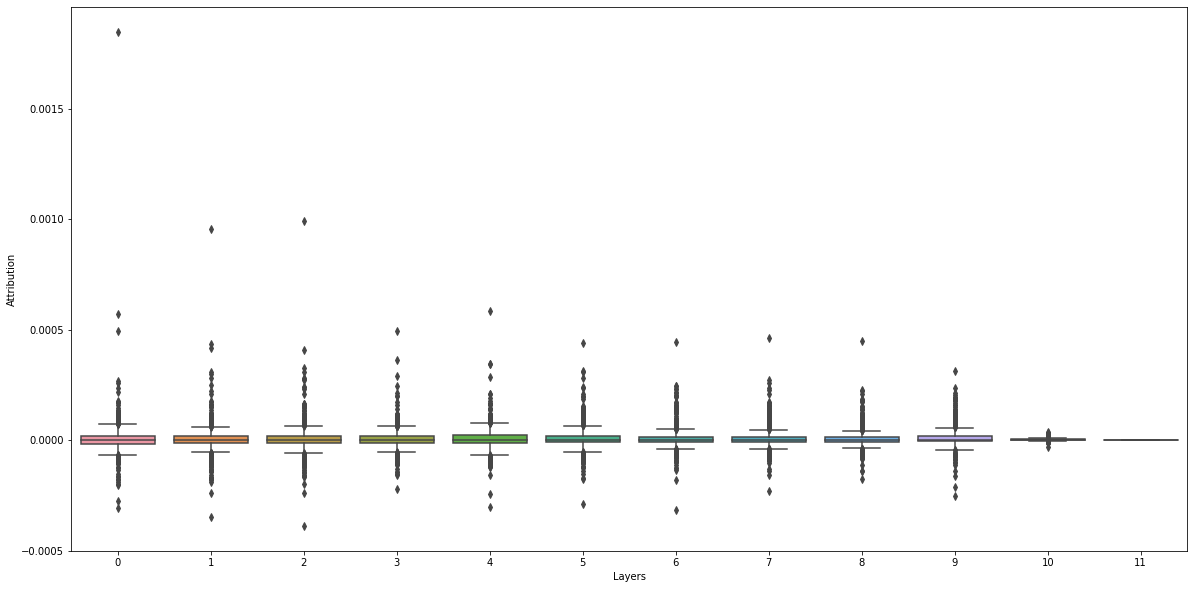

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(data=layer_attrs_dist)
plt.xlabel('Layers')
plt.ylabel('Attribution')
plt.show()

We can also represent attributions as a probability density function (pdf). This can be easily computed using a histogram where each coloured line represents a different layer. We can see kind of curves the attribution distribution for the current token is taking over all layers.

In [ ]:
def pdf_attr(attrs, bins=100):
    return np.histogram(attrs, bins=bins, density=True)[0]

In [ ]:
layer_attrs_pdf = map(lambda layer_attrs_dist: pdf_attr(layer_attrs_dist), layer_attrs_dist)
layer_attrs_pdf = np.array(list(layer_attrs_pdf))

# summing attribution along embedding diemension for each layer
# size: #layers
attr_sum = np.array(layer_attrs_dist).sum(-1)

# size: #layers
layer_attrs_pdf_norm = np.linalg.norm(layer_attrs_pdf, axis=-1, ord=1)

#size: #bins x #layers
layer_attrs_pdf = np.transpose(layer_attrs_pdf)

#size: #bins x #layers
layer_attrs_pdf = np.divide(layer_attrs_pdf, layer_attrs_pdf_norm, where=layer_attrs_pdf_norm!=0)

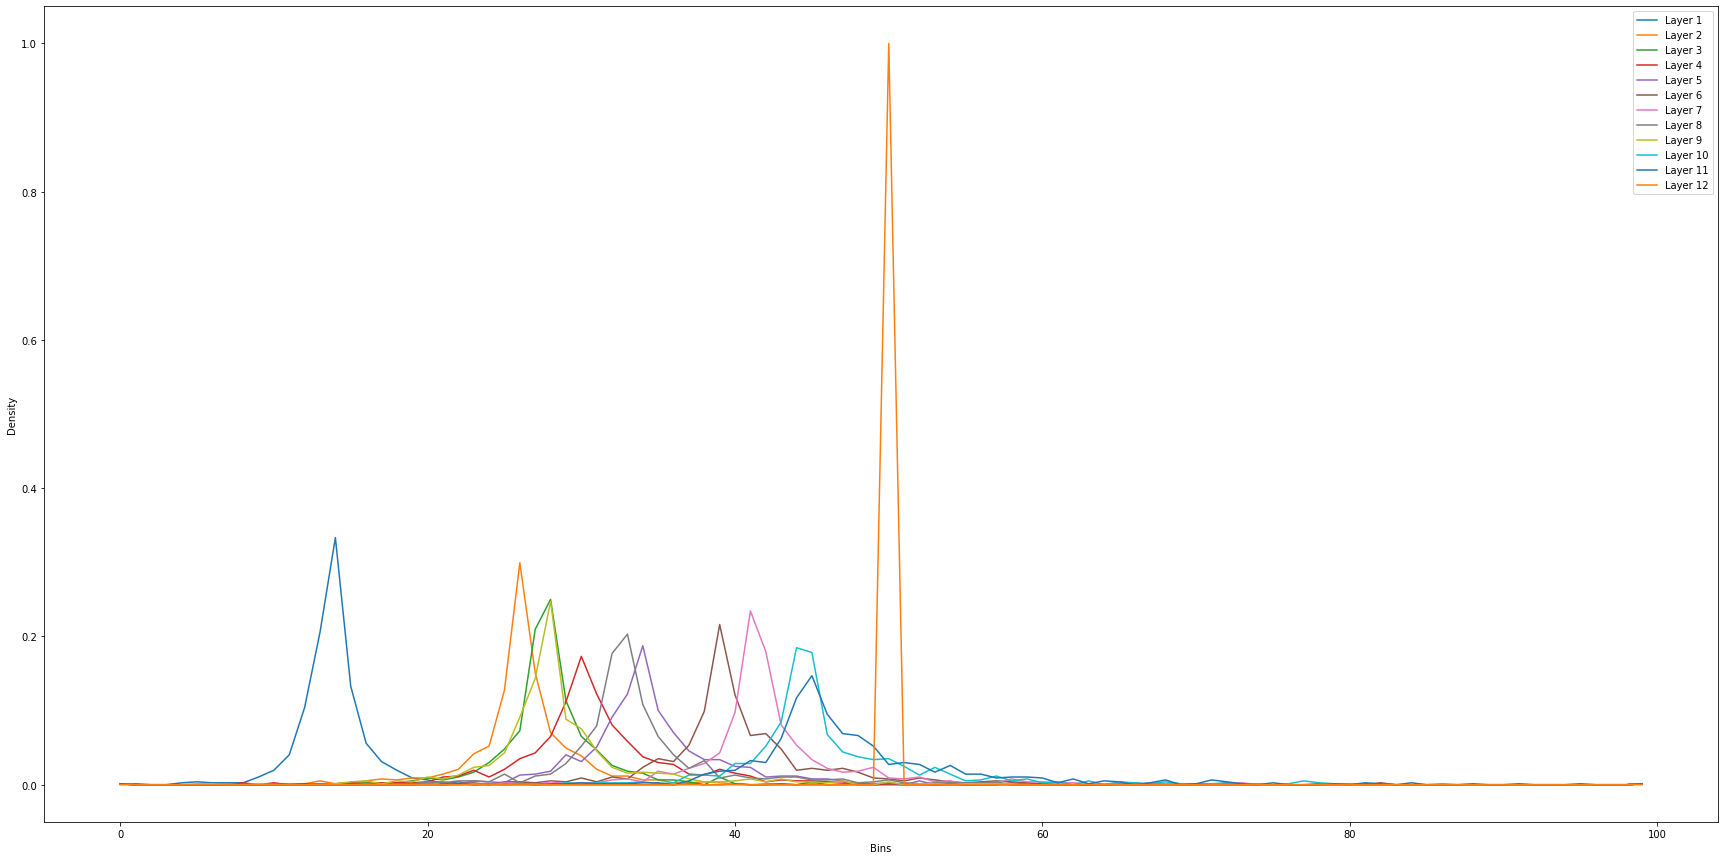

In [ ]:
fig, ax = plt.subplots(figsize=(30,15))
plt.plot(layer_attrs_pdf)
plt.xlabel('Bins')
plt.ylabel('Density')
plt.legend(['Layer '+ str(i) for i in range(1,13)])
plt.show()

We can calculate and visualize attribution entropies based on [Shannon entropy](https://people.math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf) using the density function we created above. The x-axis is the layer number and the y-axis is the total attribution in that layer. The size of the circles also correspond to the normalized entropy value. Layers that appear to be missing values may just have an attribution sum and entropy of 0.

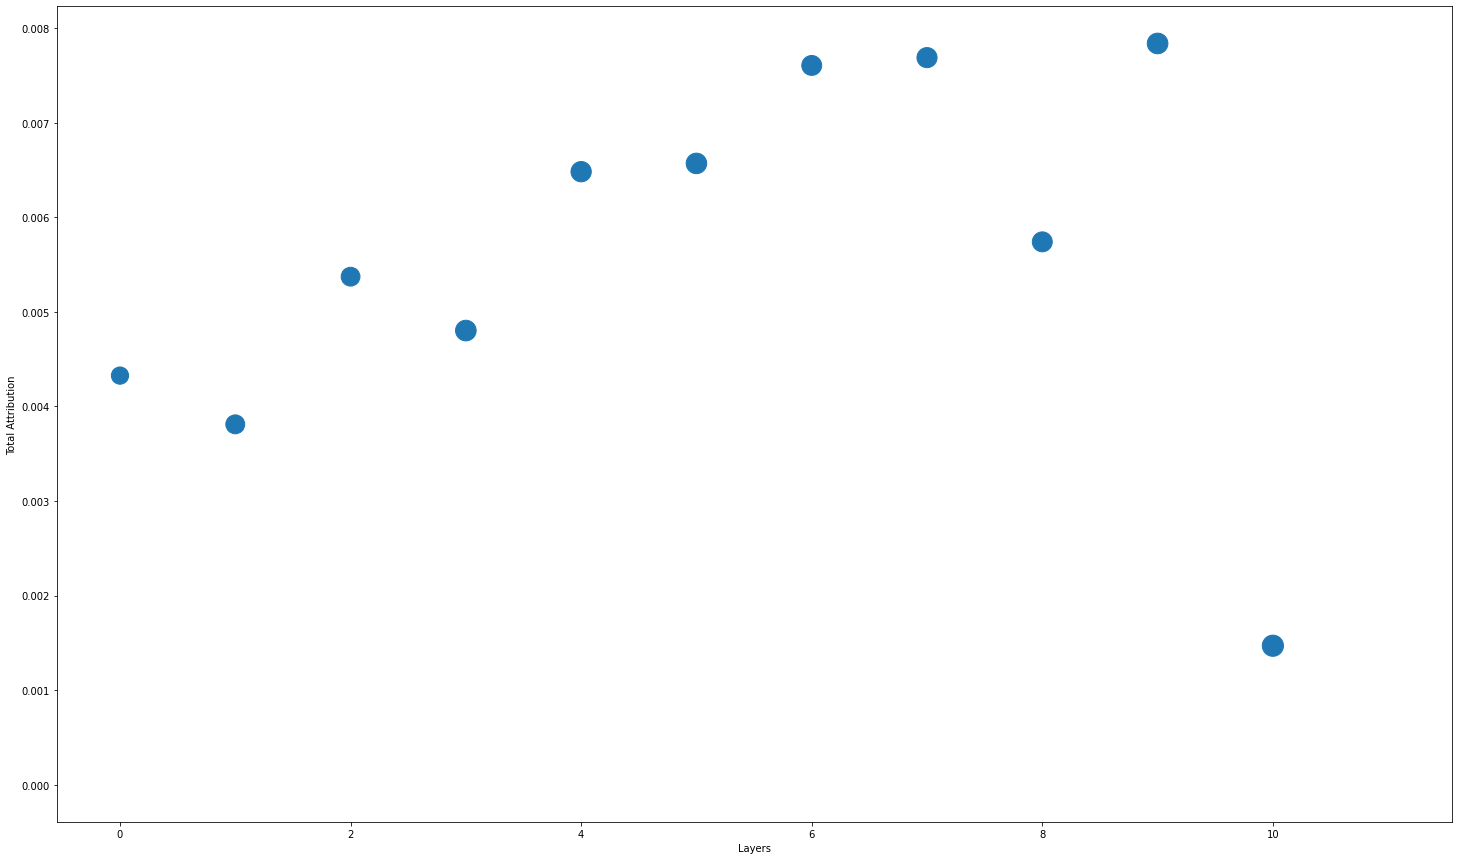

In [ ]:
fig, ax = plt.subplots(figsize=(25,15))

# replacing 0s with 1s. np.log(1) = 0 and np.log(0) = -inf
layer_attrs_pdf[layer_attrs_pdf == 0] = 1
layer_attrs_pdf_log = np.log2(layer_attrs_pdf)

# size: #layers
entropies= -(layer_attrs_pdf * layer_attrs_pdf_log).sum(0)

plt.scatter(np.arange(12), attr_sum, s=entropies * 100)
plt.xlabel('Layers')
plt.ylabel('Total Attribution')
plt.show()